In [11]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import cdt
import os
import wordcloud
import collections

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


Before comparing graphs, a common algorithm for learning graphs needs to be selected. There can be two ways of doing this - 

1. Contstructing a gene-gene interaction network using KEGG, TRRUST and CTD databases and compare that with the graphs constructed for healthy controls using different algorithms. The algorithm used to learn the graph that in a sense is closest to the CTD graph should be selected

2. Pick the algorithm that makes the most sense or has is the most meaningful in terms of the kind of data for which graphs are being learnt for.

In this script, the focus is on the graphs generated using the PC algorithm, selected using point 2

In [2]:
path = os.getcwd() + '/causal graphs/'
xls = pd.ExcelFile(path + 'PC_graphs.xlsx')

pc_graphs = {}
for sheet in xls.sheet_names:
    adjacency_df = pd.read_excel(path+'PC_graphs.xlsx', sheet_name = sheet)
    adjacency_df.rename(columns = {'Unnamed: 0':'genes'}, inplace = True)
    adjacency_df.index = adjacency_df.iloc[:,0]
    adjacency_df.drop(columns = ['genes'], inplace = True)
    pc_graphs[sheet] = nx.from_pandas_adjacency(adjacency_df, create_using=nx.DiGraph())

## Structural Hamming distance

In this section, structural hamming distance and structural intervention distance is calculated for all possible pairs of diseases with the emphasis on distance from "healthy" control network i.e. the distance of the network corresponding to each condition from the healthy network is calculated.

The plot generated in the end is for structural hamming distance. Interestingly enough, the structural intervention distance is the same for all conditions and hence was not used in the analysis. This could be because all conditions are viral respiratory disorders, belonging to a common category. It is possible that intervention distance is more generic than hamming distance. Clearly, more in depth analysis is needed to interpret the results corresponding to structural intervention distance.

In [3]:
pc_graphs.keys()

dict_keys(['Adenovirus_Simplex_virus', 'Dengue', 'Influenza', 'Paraflu_RespSyncytial', 'Pneumonia', 'Rhinovirus', 'healthy_ctrl', 'Critical', 'Non-critical'])

In [216]:
from cdt.metrics import SHD
from cdt.metrics import SID

hamming_df = pd.DataFrame(columns = list(pc_graphs.keys()), index = list(pc_graphs.keys()))
intervention_df = pd.DataFrame(columns = list(pc_graphs.keys()), index = list(pc_graphs.keys()))

for col in hamming_df.columns.to_list():
    for idx in hamming_df.index.to_list():
        hamming_df.loc[idx, col] = SHD(pc_graphs[idx], pc_graphs[col], \
                                       double_for_anticausal = True)
        intervention_df.loc[idx, col] = SID(pc_graphs[idx], pc_graphs[col])

In [16]:
hamming_df.to_csv(os.getcwd()+'/results/structural_hamming_distance_rowsource.csv')
intervention_df.to_csv(os.getcwd()+'/results/structural_intervention_distance_rowsource.csv')

## Maximum common subnetwork

This section is focused on calculating the largest common subnetwork across all the graphs learnt especially with the graph for healthy controls

In [1]:
def find_common_subnetwork(graph1, graph2):
    '''Finds the largest common subnetwork between two directed graphs of interest.
    
       Given two directed graphs, the function iterates over the edges of one of the graphs. If an edge also
       belongs to the other graph, then the edge and its endpoints are added to the common subnetwork. Note that
       the function removes isolated nodes after iterating over all edges.
       
       Args:
           graph1 (:obj:`nx.DiGraph`): networkx directed graph object whose edges are iterated upon
           graph2 (:obj:`nx.DiGraph`): networkx directed graph object
           
       Returns:
           common_graph (:obj:`nx.DiGraph`): common subnetwork of graph1 and graph2. It is a directed graph.
    '''
    
    import networkx as nx
    if not isinstance(graph1, nx.DiGraph) or not isinstance(graph2, nx.DiGraph):
        print('Function works only for directed graphs')
        return
    
    common_graph = nx.DiGraph()
    for u,v in graph1.edges:
        if graph2.has_edge(u,v):
            common_graph.add_edge(u,v)
    # removing nodes with degree 0
    remove_nodes = [node for node, degree in dict(common_graph.degree).items() if degree == 0]
    common_graph.remove_nodes_from(remove_nodes)
    
    return common_graph

In [9]:
# finding common subnetworks between all possible pairs of conditions

subnetworks = {}
for c1 in pc_graphs.keys():
    subnetworks[c1] = {}
    writer = pd.ExcelWriter(os.getcwd() +'/results/subnetworks/common_with_'+str(c1)+'.xlsx', \
                            engine = 'xlsxwriter')
    for c2 in pc_graphs.keys():
        if c1 == c2:
            continue
        else:
            common_graph = find_common_subnetwork(pc_graphs[c1], pc_graphs[c2])
            subnetworks[c1][c2] = common_graph
            nx.to_pandas_adjacency(common_graph).to_excel(writer, sheet_name = c2)
    writer.save()

In [10]:
# finding common subnetworks for combination of 3 conditions

# Pneumonia + Influenza + Critical
common_PneuInfCrit = find_common_subnetwork(subnetworks['Pneumonia']['Influenza'], pc_graphs['Critical'])

# Pneumonia + Influenza + Non-critical
common_PneuInfNonCrit = find_common_subnetwork(subnetworks['Pneumonia']['Influenza'], pc_graphs['Non-critical'])

# Rhinovirus + Influenza + Critical
common_RhinoInfCrit = find_common_subnetwork(subnetworks['Rhinovirus']['Influenza'], pc_graphs['Critical'])

# Rhinovirus + Influenza + Non-critical
common_RhinoInfNonCrit = find_common_subnetwork(subnetworks['Rhinovirus']['Influenza'], pc_graphs['Non-critical'])

## Strongly connected components

In this section, largest strongly connected components for each graph corresponding a condition is calculated and evaluated. The evaluation is done in the last section

In [12]:
largest = max(nx.strongly_connected_components(pc_graphs['healthy_ctrl']), key = len)

In [13]:
writer = pd.ExcelWriter(os.getcwd()+'/results/subnetworks/strongly_connected_components.xlsx', \
                        engine = 'xlsxwriter')
conn_comp = {}
for c in pc_graphs.keys():
    l = list(max(nx.strongly_connected_components(pc_graphs[c]), key = len))
    pd.Series(l).to_excel(writer, sheet_name = c, index = False, header = ['genes'])
    conn_comp[c] = l
writer.save()

## Markov blanket of COVID19 drug targets + driver genes

The "driver" genes are the genes identified in the paper corresponding to COVID19 dataset as regulators of certain critical symptoms. For example, inhibition of ADAM9 ex vivo interfered with SARS-Cov-2 uptake and replication in human epithelial cells.

The aim was to see if the graphs learnt for any of the conditions contain these driver genes. If they do, then the results could be similar to the ones reported in the paper. Unfortunately none of the graphs contained any of the driver genes. This was because most of them were filtered out during post-processing of the degs. In any case, it is interesting to see that driver genes detected using a different machine learning technique did not show up or have any effect in this setup.

In [15]:
driver_genes = ['RAB10','MCEMP1','MS4A4A','GCLM','ADAM9']

In [16]:
for c in pc_graphs.keys():
    flag = 1
    if len([x for x in driver_genes if x in pc_graphs[c].nodes])!=0:
        print('Condition {} graph contains driver genes'.format(c))
        flag = 0
if flag:
    print('None of the graphs learnt contain driver genes')

None of the graphs learnt contain driver genes


In [2]:
def markov_blanket(graph_oi, node_oi):
    '''Calculates the markov blanket of a node of interest in a given graph. The function returns None is the
       node is not present in the graph.
    
       Args:
           graph_oi (:obj:`nx.DiGraph`): networkx directed graph of interest that is used to calculate the 
           markov blanket
           node_oi (:obj:`str`): name of the node of interest whose markov blanket will be calculated
           
       Returns:
           mb (:obj:`np.array`): list of all nodes that belong in the markov blanket of node_oi
    '''
    
    import networkx as nx
    
    if node_oi not in graph_oi.nodes:
        print('Node not present in the graph')
        return
    parents = [x for x in graph_oi.predecessors(node_oi)]
    children = [x for x in graph_oi.successors(node_oi)]
    child_parents = []
    if len(children) != 0:
        for child in children:
            child_parents.extend([x for x in graph_oi.predecessors(child)])
    mb = np.unique(parents + children + child_parents)
    return mb

## GO/Phenotype of markov blanket & common subnetwork

CTD database was used to extract information about phenotypes, gene ontology terms and drug-gene interactions. All the individual datasets are loaded below.

In [19]:
# loading all datasets
path_ctd = '/Users/shrutikaushal/Desktop/Semester 1/Graphical Models/Final Project/CTD/'
chem2gene = pd.read_csv(path_ctd + 'CTD_chem_gene_ixns.tsv', sep = '\t')
chem2go = pd.read_csv(path_ctd + 'CTD_diseases_pathways.csv')
gene2go = pd.read_csv(path_ctd + 'CTD_genes_pathways.csv')
chem2gene2phene = pd.read_csv(path_ctd + 'CTD_Phenotype-Disease_biological_process_associations.csv')

In [12]:
# generating wordclouds using frequencies

def generate_wordcloud(l,save_plot = True, save_path = os.getcwd()+'/', fig_name = 'wordcloud'):
    '''Function generates a wordcloud for a list of strings l using frequencies instead of arithmetic mean. It
       also gives the user an option to save the figure in a directory of choice. If these choices are not 
       provided then the figure is saved in the current working directory as `wordcloud.png`.
       
       Args:
           l (:obj:`list`): list of strings which will be used to generate a wordcloud
           save_plot (:obj:`Bool`): If True, the function will save the plot otherwise it will only display it
           save_path (:obj:`str`): string specifying path to directory where the plot will be saved
           fig_name (:obj:`str`): name of the figure
    '''
    
    from wordcloud import WordCloud
    import collections
    import os
    from itertools import chain
    
    l = list(chain(*list(map(lambda x: x.split(', '), l))))
    l = collections.Counter(l)
    wc = WordCloud(background_color="white",min_font_size = 4)
    # generate word cloud
    wc.generate_from_frequencies(l)
    # plt.figure(figsize = (15,7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    if save_plot:
        plt.savefig(save_path + fig_name + '.png',bbox_inches = 'tight')
    plt.show()

### Markov Blanket of drug targets

Drugs of interest (drugs_oi) were extracted from ClinicalTrials.gov and include all the drugs that are currently in clinical trials for COVID19. Drugs were not differentiated on the basis of the phase of the trial. The drug targets were intialized manually using the information available on drugbank and CTD databses.

The aim was to calculate the markov blankets of the targets of all drugs. The motivation is the property of markov blanket itself - a node is conditionally independent of all other nodes given its markov blanket. Given this is true, finding the markov blanket of a gene in a gene-regulatory network would be equivalent to finding its control set. If a gene is known to have a positive effect on treating COVID19, genes in its markov blanket could potentially be explored for designing new drug therapies.

This section involves calculating the markov blankets of all drug tragets and enriching them with GO terms. 

In [140]:
drugs_oi = ['high-dose Vitamin C', 'remdesivir', 'favipiravir', 'adalimumab', 'dihydro-artemisinin piperaquine', \
            'leflunomide', 'dipyridamole', 'chloroquine', 'hydroxychloroquine', 'suramin sodium', 'lopinavir',\
            'ritonavir', 'arbidol', 'umifenovir', 'IFN-alpha 2b','dexamethasone']

In [147]:
drug_target = {}
drug_target['favipiravir'] = ['PB1']
drug_target['adalimumab'] = ['TNF']
drug_target['leflunomide'] = ['DHODH','AHR','PTK2B']
drug_target['dipyridamole'] = ['PDE10A','ADA','PDE5A','PDE4A','RCAN1','ORM1']
drug_target['chloroquine'] = ['GSTA2','TNF','TLR9','GST','HMGB1','GSTM1','ACE2']
drug_target['hydroxychloroquine'] = ['TLR7','TLR9','ACE2']
drug_target['suramin'] = ['P2RY2','SIRT5','FSHR','RYR1','F2','PLA2G2A']
drug_target['ritonavir'] = ['NR1I2']
drug_target['dexamethasone'] = ['NR3C1','ANXA1','NR0B1','NOS2','NR1I2']

In [148]:
targets = []
for key in drug_target.keys():
    targets.extend(drug_target[key])

In [153]:
[x for x in np.unique(targets) if x in pc_graphs['Non-critical'].nodes]

['ANXA1']

In [158]:
l1 = markov_blanket(pc_graphs['Non-critical'],'ANXA1')
l2 = markov_blanket(pc_graphs['Critical'],'ANXA1')
l = np.unique(list(l1)+list(l2))

In [166]:
l

array(['ANXA1', 'MMADHC', 'PCMT1', 'VPS29'], dtype='<U6')

In [165]:
list(gene2go[gene2go['GeneSymbol'].isin(l)]['PathwayName'])

['Class A/1 (Rhodopsin-like receptors)',
 'Cytokine Signaling in Immune system',
 'Formyl peptide receptors bind formyl peptides and many other ligands',
 'G alpha (i) signalling events',
 'G alpha (q) signalling events',
 'Gastrin-CREB signalling pathway via PKC and MAPK',
 'GPCR downstream signaling',
 'GPCR ligand binding',
 'Immune System',
 'Interleukin-4 and 13 signaling',
 'Muscle contraction',
 'Peptide ligand-binding receptors',
 'Signaling by GPCR',
 'Signaling by Interleukins',
 'Signal Transduction',
 'Smooth Muscle Contraction',
 'Cobalamin (Cbl, vitamin B12) transport and metabolism',
 'Defective MMADHC causes methylmalonic aciduria and homocystinuria type cblD',
 'Defects in cobalamin (B12) metabolism',
 'Defects in vitamin and cofactor metabolism',
 'Disease',
 'Diseases of metabolism',
 'Metabolism',
 'Metabolism of vitamins and cofactors',
 'Metabolism of water-soluble vitamins and cofactors',
 'Metabolism of proteins',
 'Protein repair',
 'Endocytosis',
 'Signaling b

### GO terms for strongly connected components

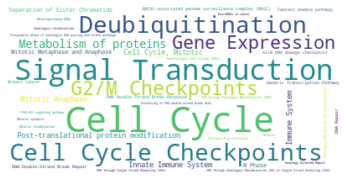

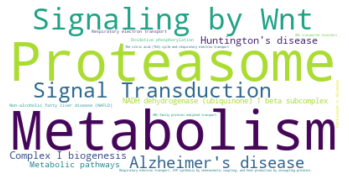

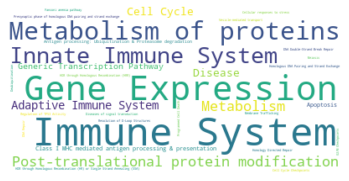

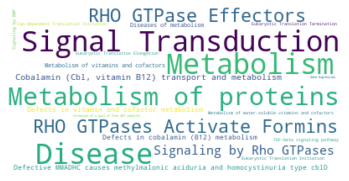

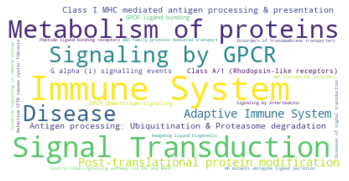

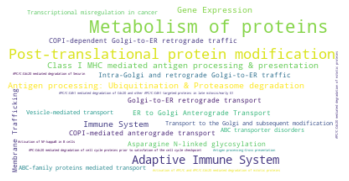

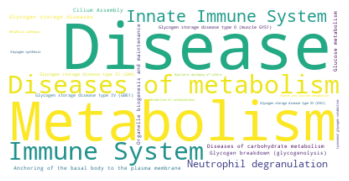

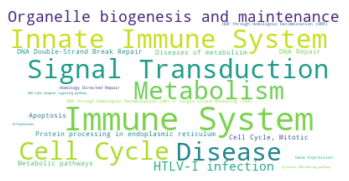

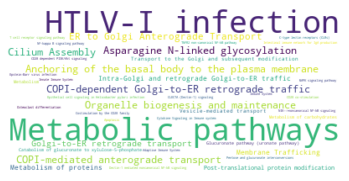

In [77]:
fig_path = os.getcwd()+'/results/figures/wordclouds/Gene GO/'
go_conn_comp = {}
for c in conn_comp.keys():
    go_conn_comp[c] = list(gene2go[gene2go['GeneSymbol'].isin(conn_comp[c])]['PathwayName'])
    generate_wordcloud(l = go_conn_comp[c], save_path = fig_path, fig_name = str(c)+'_geneGO')

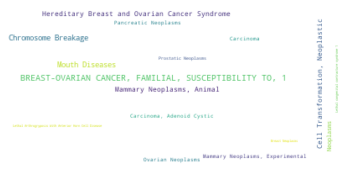

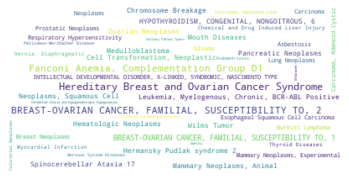

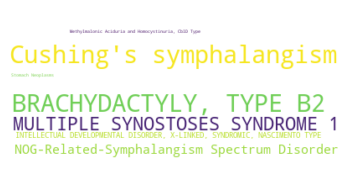

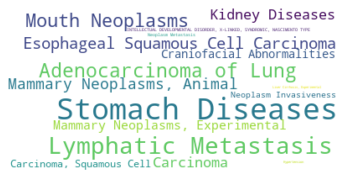

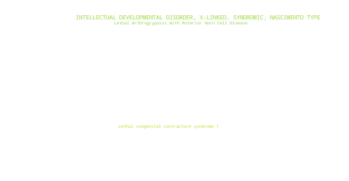

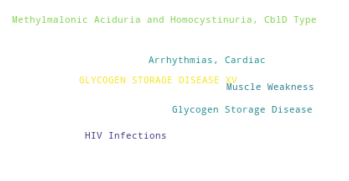

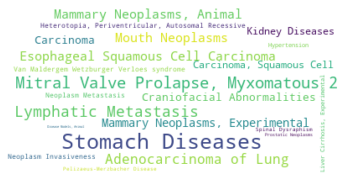

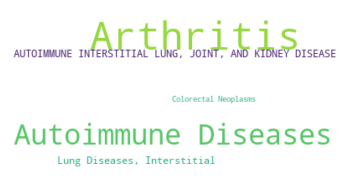

In [81]:
fig_path = os.getcwd()+'/results/figures/wordclouds/Inferred disease/'
disease_conn_comp = {}
for c in conn_comp.keys():
    disease_conn_comp[c] = list(chem2gene2phene[chem2gene2phene['InferenceGeneSymbols'].isin(conn_comp[c])]['DiseaseName'])
    if len(disease_conn_comp[c])>2:
        generate_wordcloud(l = disease_conn_comp[c], save_path = fig_path, fig_name = str(c)+'_geneDisease')

### GO terms for common subnetworks

In [85]:
list(gene2go[gene2go['GeneSymbol'].isin(list(common_PneuInfCrit.nodes()))]['PathwayName'])

['Class A/1 (Rhodopsin-like receptors)',
 'Cytokine Signaling in Immune system',
 'Formyl peptide receptors bind formyl peptides and many other ligands',
 'G alpha (i) signalling events',
 'G alpha (q) signalling events',
 'Gastrin-CREB signalling pathway via PKC and MAPK',
 'GPCR downstream signaling',
 'GPCR ligand binding',
 'Immune System',
 'Interleukin-4 and 13 signaling',
 'Muscle contraction',
 'Peptide ligand-binding receptors',
 'Signaling by GPCR',
 'Signaling by Interleukins',
 'Signal Transduction',
 'Smooth Muscle Contraction',
 'Metabolism of proteins',
 'Protein repair']

In [89]:
list(gene2go[gene2go['GeneSymbol'].isin(list(common_PneuInfNonCrit.nodes()))]['PathwayName'])

['Cytosolic DNA-sensing pathway',
 'Immune System',
 'Inflammasomes',
 'Innate Immune System',
 'NOD-like receptor signaling pathway',
 'Nucleotide-binding domain, leucine rich repeat containing receptor (NLR) signaling pathways',
 'The AIM2 inflammasome',
 'Adaptive Immune System',
 'Antigen processing: Ubiquitination & Proteasome degradation',
 'Class I MHC mediated antigen processing & presentation',
 'Immune System']

In [87]:
list(gene2go[gene2go['GeneSymbol'].isin(list(common_RhinoInfNonCrit.nodes()))]['PathwayName'])

['Cytosolic DNA-sensing pathway',
 'Immune System',
 'Inflammasomes',
 'Innate Immune System',
 'NOD-like receptor signaling pathway',
 'Nucleotide-binding domain, leucine rich repeat containing receptor (NLR) signaling pathways',
 'The AIM2 inflammasome',
 'Adaptive Immune System',
 'Antigen processing: Ubiquitination & Proteasome degradation',
 'Class I MHC mediated antigen processing & presentation',
 'Immune System']

In [88]:
list(gene2go[gene2go['GeneSymbol'].isin(list(common_RhinoInfCrit.nodes()))]['PathwayName'])

['Disease',
 'Diseases of carbohydrate metabolism',
 'Diseases of metabolism',
 'Glucose metabolism',
 'Glycogen breakdown (glycogenolysis)',
 'Glycogen storage diseases',
 'Glycogen storage disease type 0 (muscle GYS1)',
 'Glycogen storage disease type II (GAA)',
 'Glycogen storage disease type IV (GBE1)',
 'Glycogen storage disease type XV (GYG1)',
 'Glycogen synthesis',
 'Immune System',
 'Innate Immune System',
 'Lysosomal glycogen catabolism',
 'Metabolic pathways',
 'Metabolism',
 'Metabolism of carbohydrates',
 'Myoclonic epilepsy of Lafora',
 'Neutrophil degranulation',
 'Starch and sucrose metabolism',
 'Cobalamin (Cbl, vitamin B12) transport and metabolism',
 'Defective MMADHC causes methylmalonic aciduria and homocystinuria type cblD',
 'Defects in cobalamin (B12) metabolism',
 'Defects in vitamin and cofactor metabolism',
 'Disease',
 'Diseases of metabolism',
 'Metabolism',
 'Metabolism of vitamins and cofactors',
 'Metabolism of water-soluble vitamins and cofactors']

In [ ]:
list(gene2go[gene2go['GeneSymbol'].isin(list(common_RhinoInfCrit.nodes()))]['PathwayName'])

In [90]:
list(gene2go[gene2go['GeneSymbol'].isin(list(subnetworks['Rhinovirus']['Non-critical'].nodes()))]['PathwayName'])

['Defective B3GALTL causes Peters-plus syndrome (PpS)',
 'Disease',
 'Diseases associated with O-glycosylation of proteins',
 'Diseases of glycosylation',
 'Metabolism of proteins',
 'O-glycosylation of TSR domain-containing proteins',
 'O-linked glycosylation',
 'Post-translational protein modification',
 'Cytosolic DNA-sensing pathway',
 'Immune System',
 'Inflammasomes',
 'Innate Immune System',
 'NOD-like receptor signaling pathway',
 'Nucleotide-binding domain, leucine rich repeat containing receptor (NLR) signaling pathways',
 'The AIM2 inflammasome',
 'Assembly of collagen fibrils and other multimeric structures',
 'Axon guidance',
 'Collagen biosynthesis and modifying enzymes',
 'Collagen chain trimerization',
 'Collagen formation',
 'Developmental Biology',
 'ECM-receptor interaction',
 'Extracellular matrix organization',
 'Focal adhesion',
 'NCAM1 interactions',
 'NCAM signaling for neurite out-growth',
 'PI3K-Akt signaling pathway',
 'Protein digestion and absorption',
 'Si

## Degree distribution of causal networks

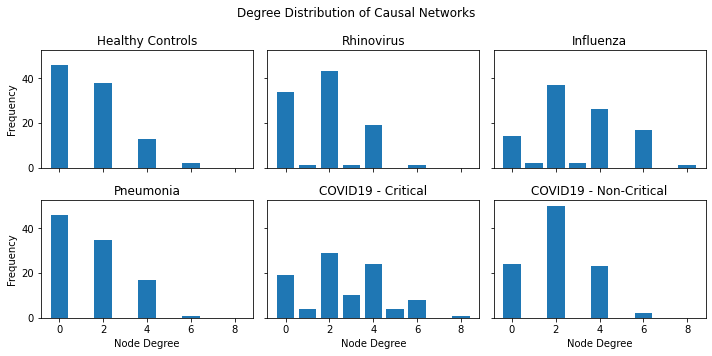

In [139]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (10,5))

degree_sequence = sorted((d for n, d in pc_graphs['healthy_ctrl'].degree()), reverse=True)
dmax = max(degree_sequence)
axs[0,0].bar(*np.unique(degree_sequence, return_counts=True))
axs[0,0].set_title('Healthy Controls')

degree_sequence = sorted((d for n, d in pc_graphs['Rhinovirus'].degree()), reverse=True)
dmax = max(degree_sequence)
axs[0,1].bar(*np.unique(degree_sequence, return_counts=True))
axs[0,1].set_title('Rhinovirus')

degree_sequence = sorted((d for n, d in pc_graphs['Influenza'].degree()), reverse=True)
dmax = max(degree_sequence)
axs[0,2].bar(*np.unique(degree_sequence, return_counts=True))
axs[0,2].set_title('Influenza')

degree_sequence = sorted((d for n, d in pc_graphs['Pneumonia'].degree()), reverse=True)
dmax = max(degree_sequence)
axs[1,0].bar(*np.unique(degree_sequence, return_counts=True))
axs[1,0].set_title('Pneumonia')

degree_sequence = sorted((d for n, d in pc_graphs['Critical'].degree()), reverse=True)
dmax = max(degree_sequence)
axs[1,1].bar(*np.unique(degree_sequence, return_counts=True))
axs[1,1].set_title('COVID19 - Critical')

degree_sequence = sorted((d for n, d in pc_graphs['Non-critical'].degree()), reverse=True)
dmax = max(degree_sequence)
axs[1,2].bar(*np.unique(degree_sequence, return_counts=True))
axs[1,2].set_title('COVID19 - Non-Critical')

fig.suptitle('Degree Distribution of Causal Networks')
plt.setp(axs[-1, :], xlabel='Node Degree')
plt.setp(axs[:, 0], ylabel='Frequency')
fig.tight_layout()
plt.savefig(os.getcwd()+'/results/figures/degree_distribution.png', bbox_inches = 'tight')
plt.show()

In [199]:
hamming_df = pd.read_csv(os.getcwd()+'/results/metrics/structural_hamming_distance_rowsource.csv')
hamming_df.drop(columns = ['Adenovirus_Simplex_virus','Paraflu_RespSyncytial'], inplace = True)
hamming_df.drop([1,4], axis = 0, inplace = True)

intervention_df = pd.read_csv(os.getcwd()+'/results/metrics/structural_intervention_distance_rowsource.csv')
intervention_df.drop(columns = ['Adenovirus_Simplex_virus','Paraflu_RespSyncytial'], inplace = True)
intervention_df.drop([1,4], axis = 0, inplace = True)

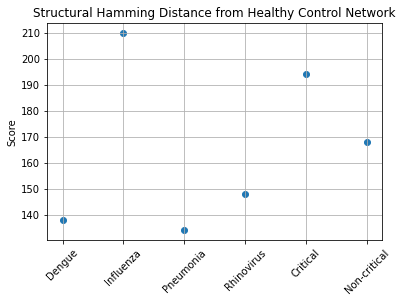

In [215]:
x = hamming_df.columns.to_list()[2:]
y = hamming_df[hamming_df['Unnamed: 0'] == 'healthy_ctrl'].iloc[:,2:].values[0]
plt.scatter(x,y)
plt.xticks(rotation = 45)
plt.grid()
plt.title('Structural Hamming Distance from Healthy Control Network')
plt.ylabel('Score')
plt.savefig(os.getcwd()+'/results/figures/hamming_distance.png', bbox_inches = 'tight')
plt.show()